In [4]:
import importlib
from utils import *
utils = importlib.import_module('utils')
importlib.reload(utils)

from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [3]:
ref_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/references/'
ref_image_names = os.listdir(ref_dir)
ref_images = [cv2.imread(os.path.join(ref_dir, img)) for img in ref_image_names]
ref_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in ref_images]
ref_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in ref_images]
ref_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in ref_images]

In [5]:
def find_mask(img_gray: np.ndarray, name: str) -> np.ndarray:
    edges = canny(img_gray)
    
    if "White" in name or "Comtesse" in name:
        result = hough_ellipse(edges, accuracy=20, threshold=4, min_size=4)
        result.sort(order='accumulator')

        best = list(result[-1])
        yc, xc, a, b = (int(round(x)) for x in best[1:5])
        orientation = best[5]

        cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
        edges = np.zeros(img_gray.shape)
        edges[cy, cx] = 1
        
    kernel = np.ones((5,5))
    edges = closing(edges, kernel)
    mask = remove_small_holes(edges.astype(dtype=np.bool), area_threshold=500000)
    mask = opening(mask)

    return mask

In [7]:
masks = []

for name, image in zip(ref_image_names, ref_images_gray):
    masks.append(find_mask(img_gray=image, name=name))

In [44]:
overlap_ratio = 0.5  # 50% overlap

bbox_coords = []
bbox_sizes = []
masks = []

for name, image in zip(ref_image_names, ref_images_gray):
    masks.append(find_mask(img_gray=image, name=name))

max_height = 0
max_width = 0

for i, mask in enumerate(masks):
    ys, xs = np.where(mask)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    h = y_max - y_min
    w = x_max - x_min
    bbox_coords.append((y_min, y_max, x_min, x_max))
    bbox_sizes.append((h, w))

    max_height = max(max_height, h)
    max_width = max(max_width, w)

min_height = min(h for h, w in bbox_sizes)
min_width = min(w for h, w in bbox_sizes)
min_size = (min_height // 2, min_width // 2)

stride_y = int(min_size[0] * (1 - overlap_ratio))
stride_x = int(min_size[1] * (1 - overlap_ratio))

reference_feature_vectors = []
selected_bbox_coords = []

for i in range(len(ref_images)):
    y_min, y_max, x_min, x_max = bbox_coords[i]
    mask = masks[i].astype(np.uint8) * 255

    reference_features = []

    for y in range(y_min, y_max - min_size[0] + 1, stride_y):
        for x in range(x_min, x_max - min_size[1] + 1, stride_x):
            tile_mask = mask[y:y+min_size[0], x:x+min_size[1]]
            coverage = np.sum(tile_mask) / (min_size[0] * min_size[1] * 255)

            if coverage >= 0.9:
                roi = ref_images[i][y:y+min_size[0], x:x+min_size[1]]
                roi_mask = tile_mask
                feature_vec = extract_masked_features(roi, roi_mask, feature_list=None)
                reference_features.append(feature_vec)
                selected_bbox_coords.append((i, y, y + min_size[0], x, x + min_size[1]))

    reference_feature_vectors.append(reference_features)

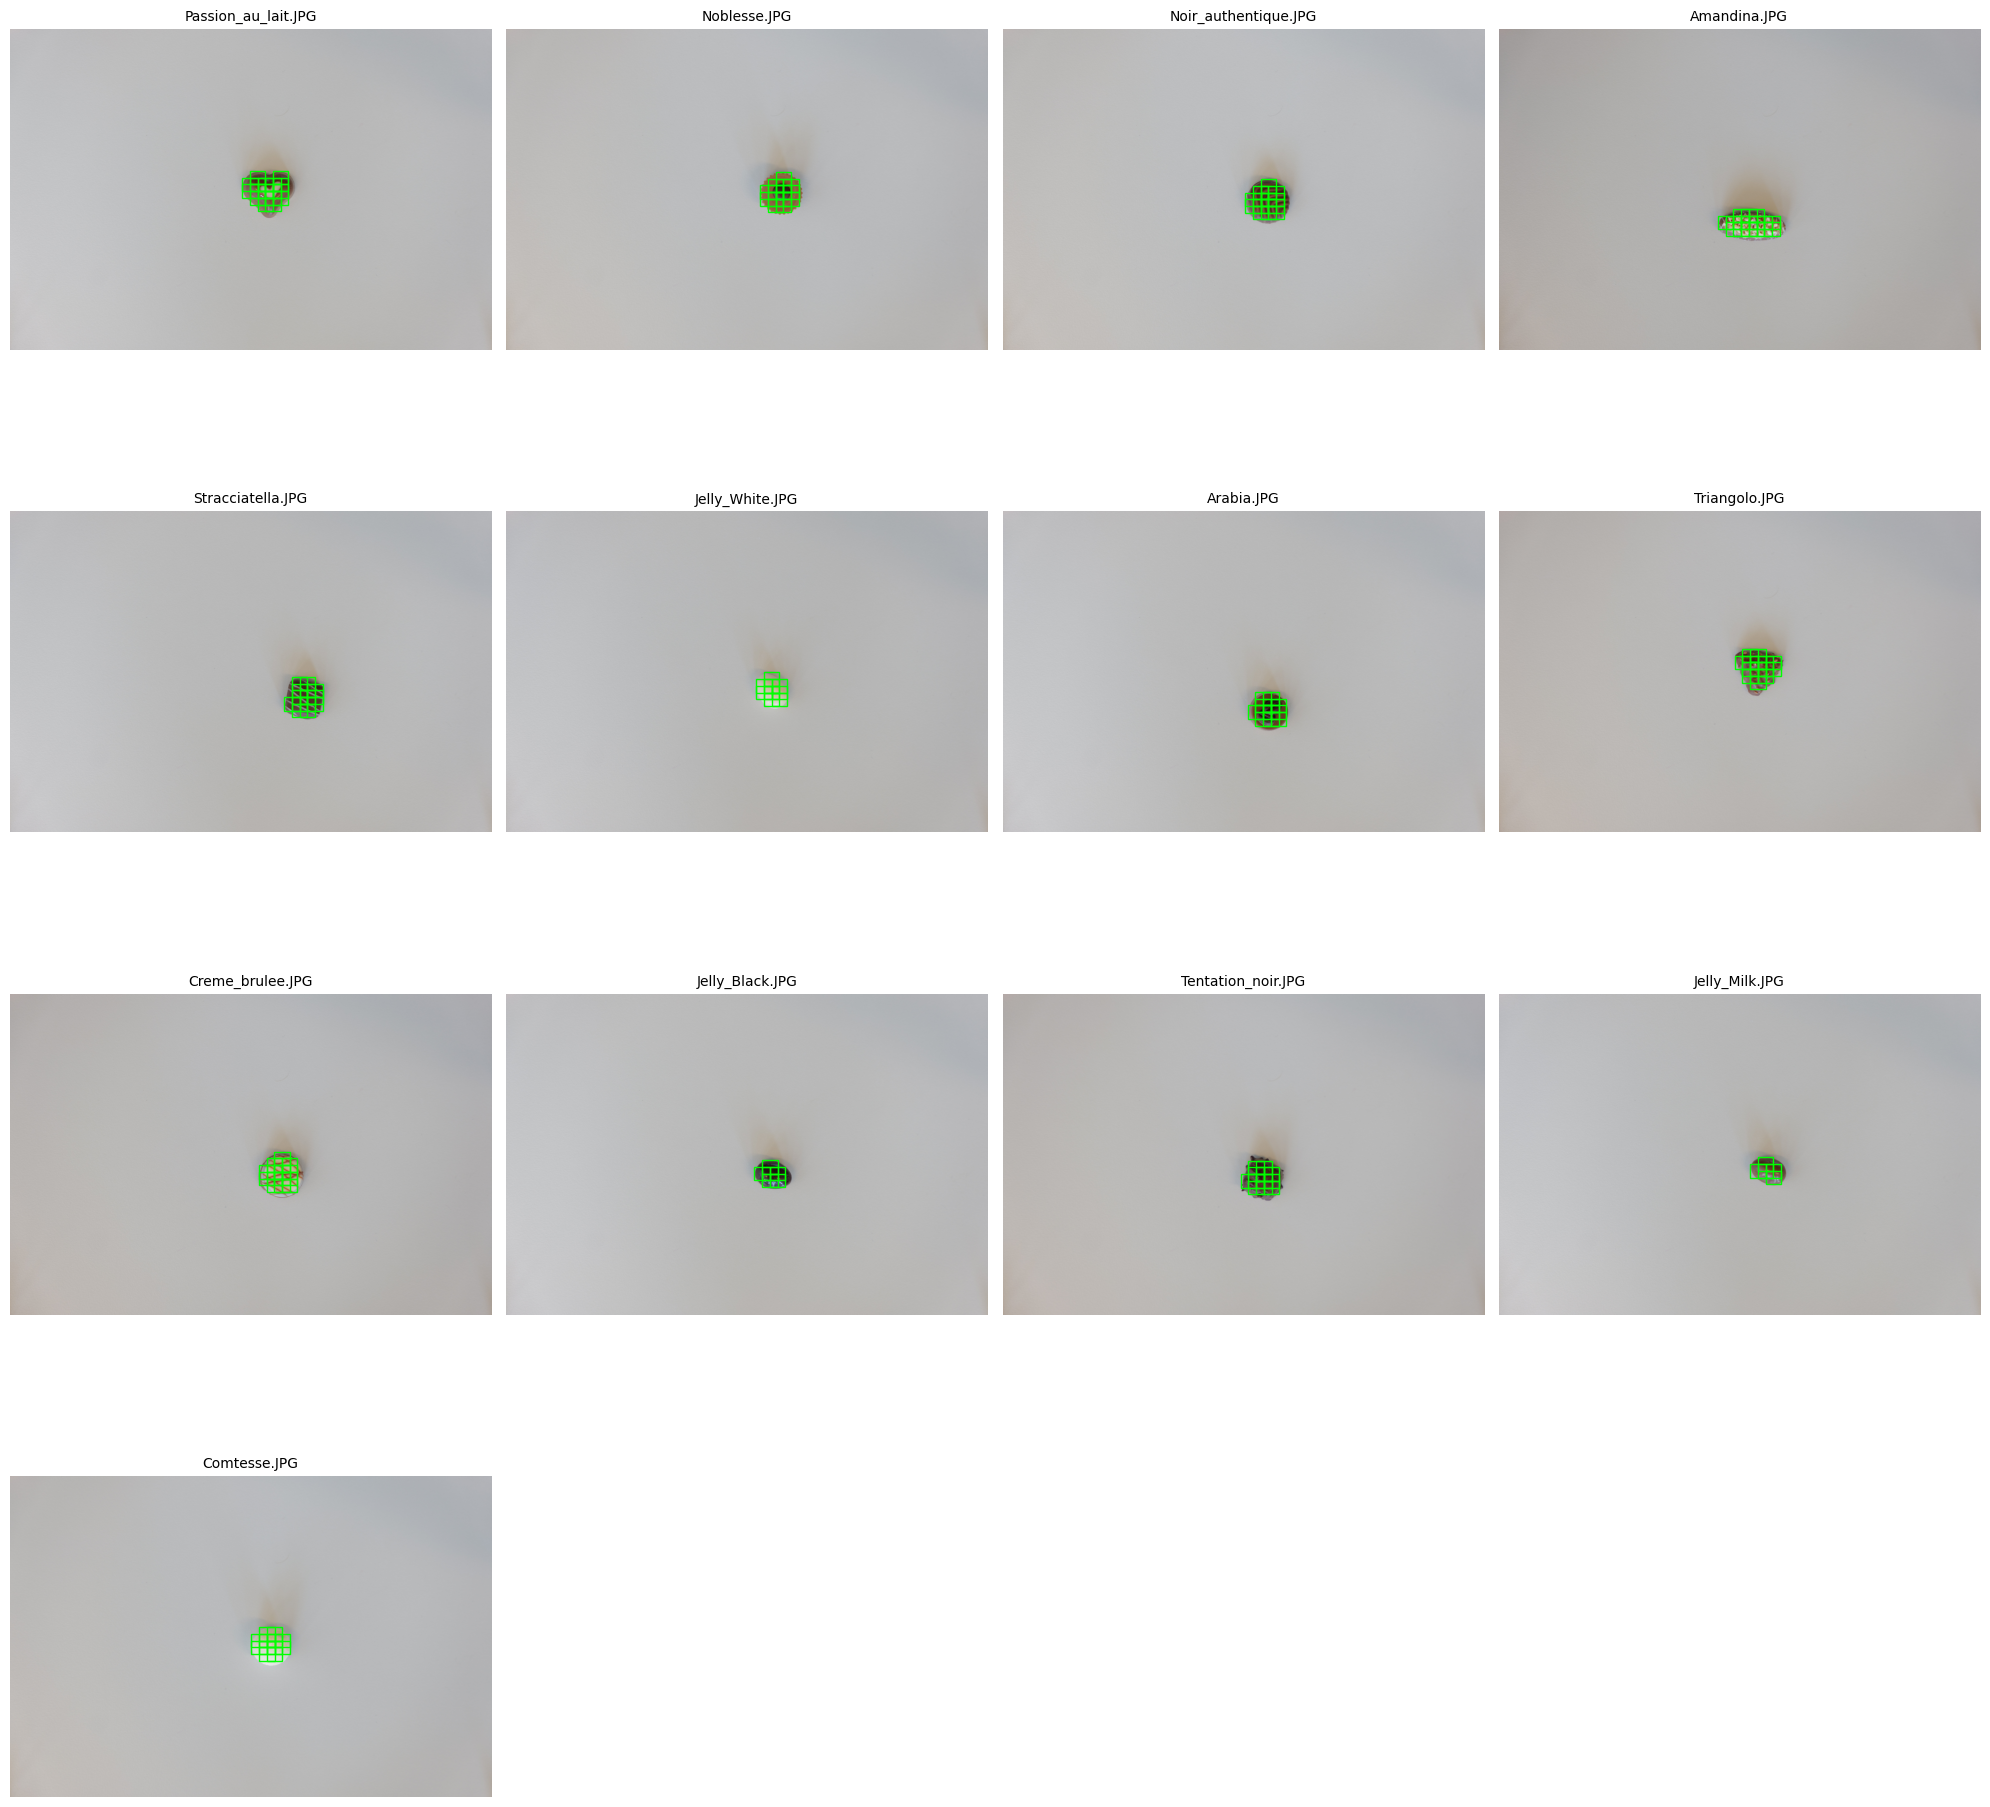

In [45]:
cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(5 * cols, 5 * rows))

for i, name in enumerate(ref_image_names):
    img = cv2.cvtColor(ref_images[i], cv2.COLOR_BGR2RGB)
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)

    for idx, y1, y2, x1, x2 in selected_bbox_coords:
        if idx == i:
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=1, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    ax.set_title(name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [69]:
print("Shape of reference feature vectors:", len(reference_feature_vectors), len(reference_feature_vectors[0]), len(reference_feature_vectors[0][0]))

Shape of reference feature vectors: 13 18 4391


PCA to reduce the dimensionality of the data

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

reduced_feature_vectors = []

feature_array = np.vstack(reference_feature_vectors)

new_array = pca.fit_transform(feature_array)

patch_counts = [len(patches) for patches in reference_feature_vectors]

reduced_feature_vectors = []
start = 0
for count in patch_counts:
    end = start + count
    reduced_feature_vectors.append(new_array[start:end])
    start = end

print("Shape of reduced feature vectors:", len(reduced_feature_vectors), len(reduced_feature_vectors[0]), len(reduced_feature_vectors[0][0]))

Shape of reduced feature vectors: 13 18 100


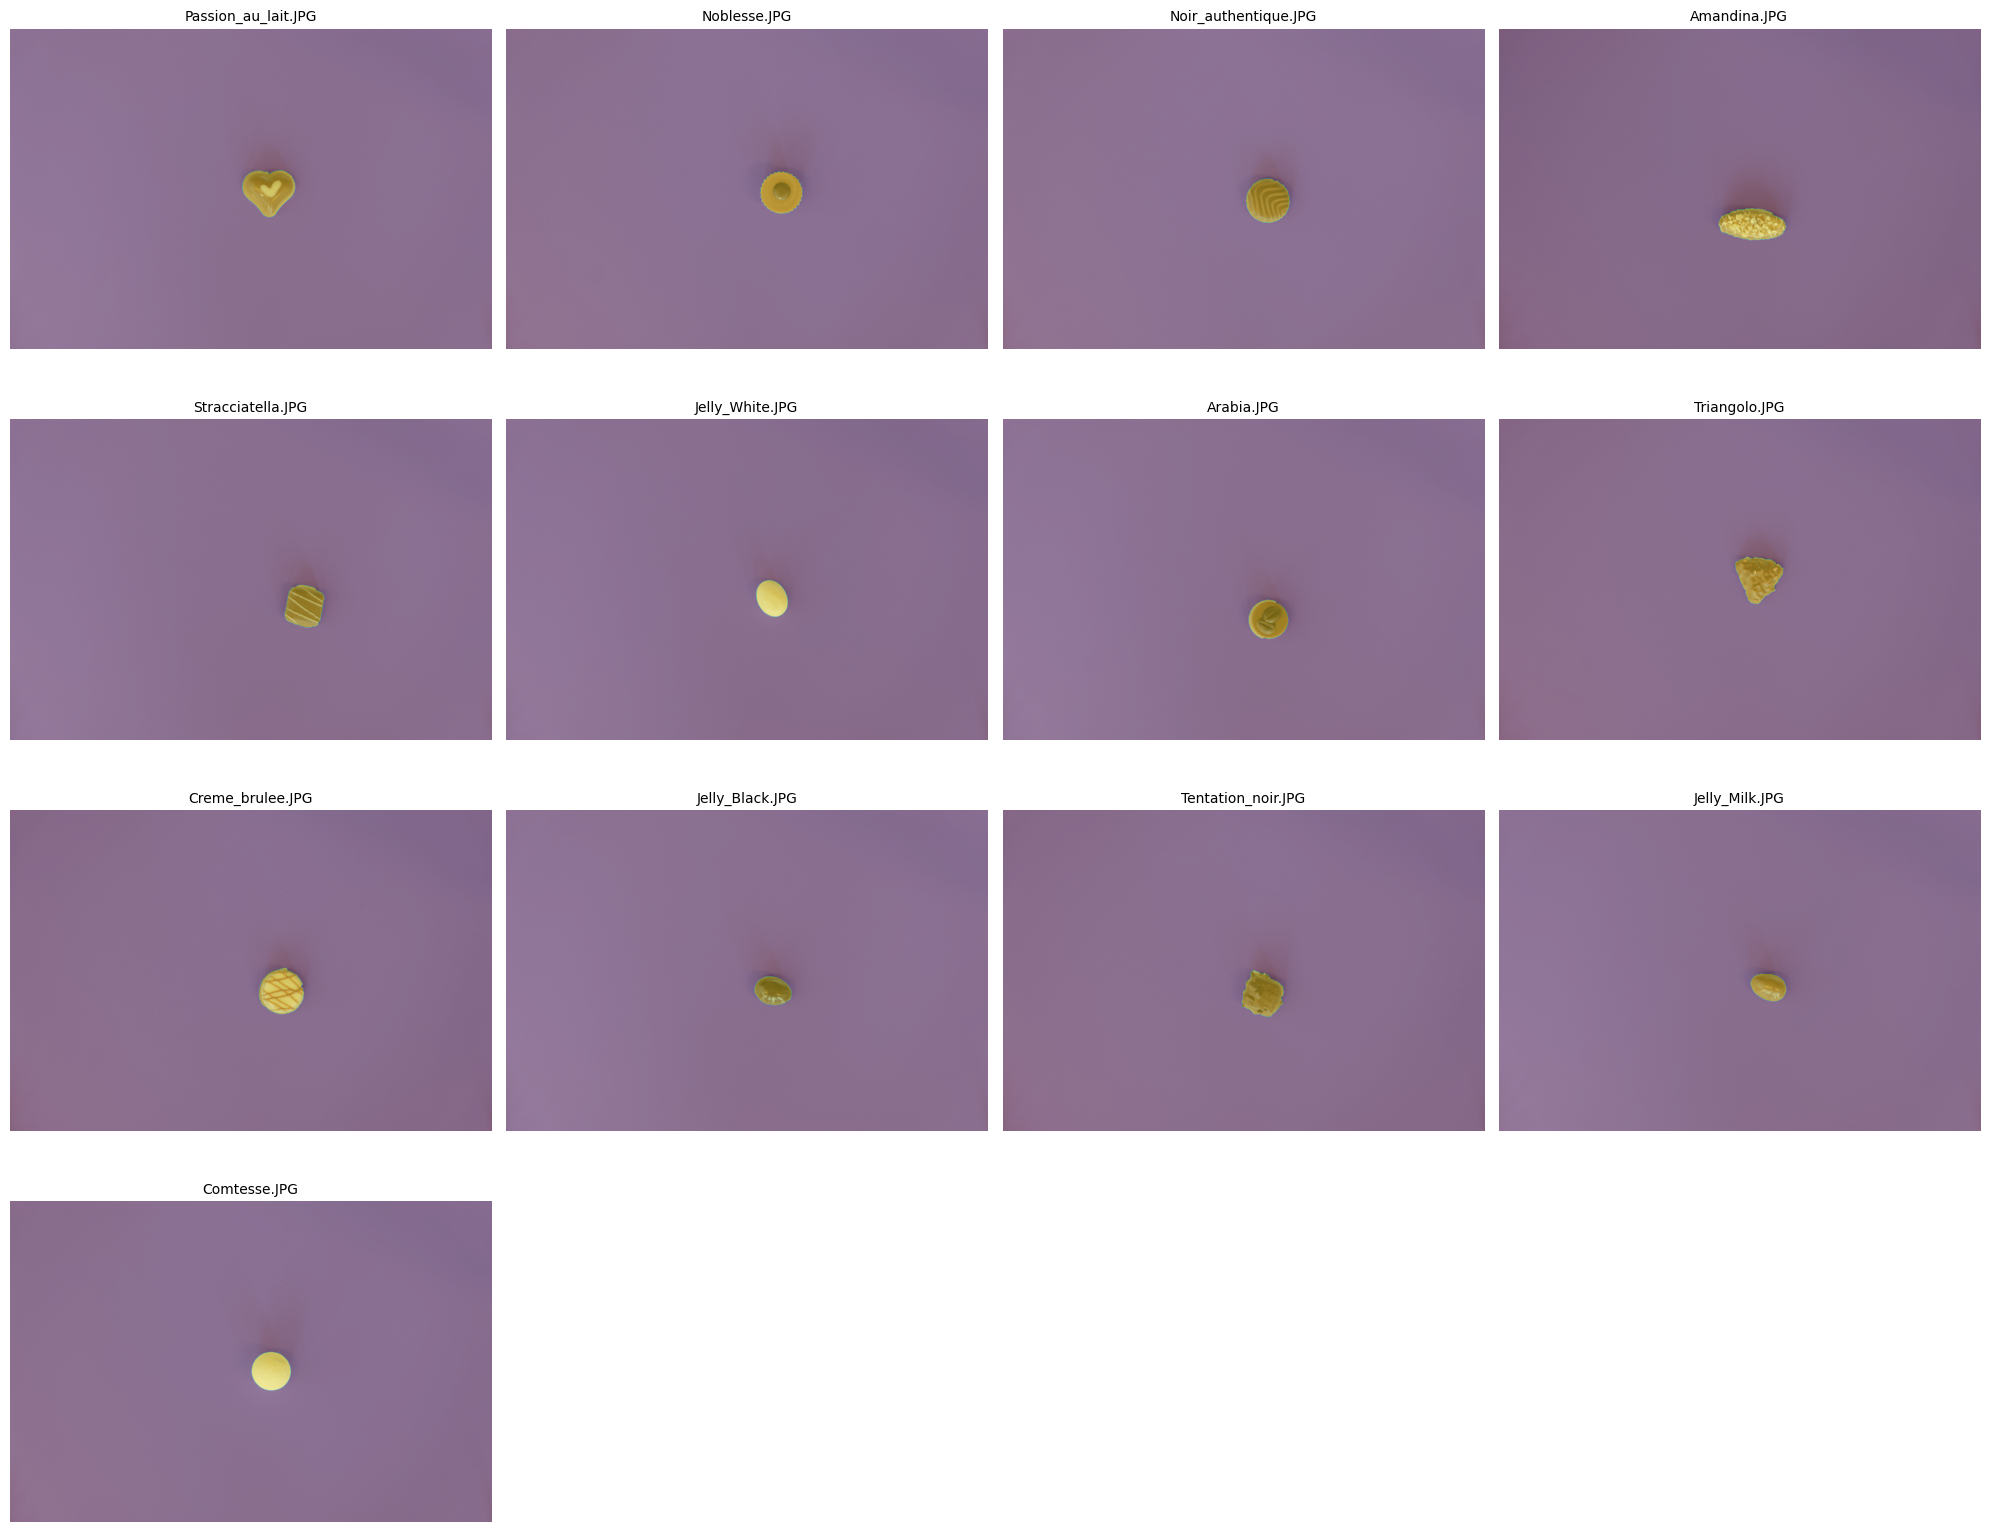

In [89]:
reference_histograms = []
cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(20, 4 * rows))

for i, (img_rgb, mask) in enumerate(zip(ref_images_rgb, masks)):
    img_rgb = img_rgb.copy()
    mask_uint8 = (mask.astype(np.uint8)) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    eroded_mask = cv2.erode(mask_uint8, kernel, iterations=1)

    hist = cv2.calcHist([img_rgb], [0, 1, 2], eroded_mask, [16, 16, 16], [0, 256]*3)
    hist = cv2.normalize(hist, hist).flatten()
    reference_histograms.append(hist)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.imshow(mask, cmap='viridis', alpha=0.4)
    plt.title(ref_image_names[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
